In [38]:
import warnings
warnings.filterwarnings('ignore')

In [39]:
from pathlib import Path
import imghdr
import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import numpy as np

# Data Preprocessing and Cleaning

In [40]:
data_dir = "hair_types"
image_extensions = [".png", ".jpg"]

img_type_accepted_by_tf = ["bmp", "gif", "jpeg", "png"]

for filepath in Path(data_dir).rglob("*"):
    if filepath.suffix.lower() in image_extensions:
        if filepath.exists():
            img_type = imghdr.what(filepath)
            if img_type is None:
                print(f"{filepath} is not an image")
                os.remove(filepath)
            elif img_type not in img_type_accepted_by_tf:
                print(f"{filepath} is a {img_type}, not accepted by TensorFlow")
                os.remove(filepath)
        else:
            print(f"{filepath} does not exist.")

hair_types\Straight_Hair\graphicstock-young-handsome-asiatic-long-brown-straight-hair-woman-taking-selfie-outdoor-in-the-city-with-a-smartphone-smiling-vanity-technology-social-network-concept_B6fyU2Ok-_SB_PM.jpg does not exist.
hair_types\Straight_Hair\graphicstock-young-handsome-caucasian-reddish-straight-hair-woman-sitting-on-a-small-wall-holding-a-tablet-taking-a-selfie-doing-grimace-technology-social-network-youthful-concept_BTFpe2_1W_SB_PM.jpg does not exist.


# Data Loading and Splitting

In [41]:
from tensorflow.keras.layers import Input, Rescaling, Conv2D, Activation, MaxPooling2D, GlobalAveragePooling2D, Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator

image_size = (64, 64)
batch_size = 32

train_images, train_labels = [], []
val_images, val_labels = [], []

for images, labels in train_ds:
    train_images.append(images.numpy())
    train_labels.append(labels.numpy())

for images, labels in val_ds:
    val_images.append(images.numpy())
    val_labels.append(labels.numpy())

train_images = np.concatenate(train_images)
train_labels = np.concatenate(train_labels)
val_images = np.concatenate(val_images)
val_labels = np.concatenate(val_labels)

# Data augmentation
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "hair_types",
    validation_split=0.2,
    subset="training",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
    labels='inferred',
    label_mode='categorical'
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "hair_types",
    validation_split=0.2,
    subset="validation",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
    labels='inferred',
    label_mode='categorical',
)

Found 981 files belonging to 3 classes.
Using 785 files for training.
Found 981 files belonging to 3 classes.
Using 196 files for validation.


# Mixed Precision Training and Data Prefetching

# Visualization of Training Data

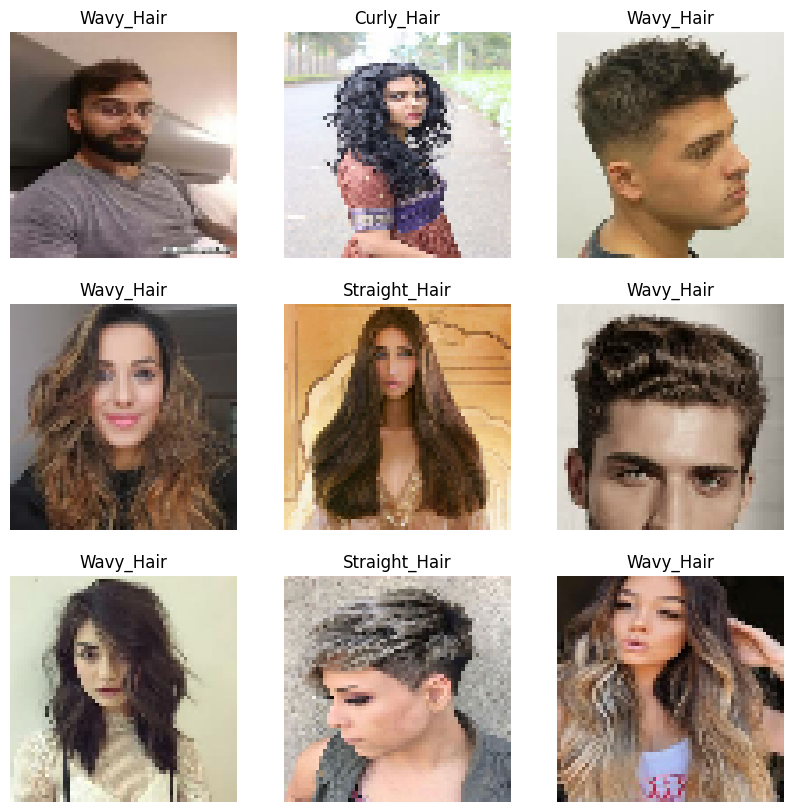

In [42]:
class_names = train_ds.class_names

# Display a batch of images
def show_batch(images, labels):
    num_images = min(images.shape[0], 9)  
    plt.figure(figsize=(10, 10))

    for i in range(num_images):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[int(np.argmax(labels[i]))])
        plt.axis("off")

    plt.show()


# Display a batch from your validation dataset
for images, labels in val_ds.take(1):
    show_batch(images, labels)

# Model Architecture

Adding max pooling layers helps reduce the spatial dimensions and control overfitting.

In [43]:
# Create a new model
hair_model = Sequential()

# Add convolutional layers, activation functions, and pooling as needed
hair_model.add(Input(shape=image_size + (3,)))
hair_model.add(Rescaling(1.0 / 255))

hair_model.add(Conv2D(filters=4, kernel_size=16, strides=1, padding='same', dilation_rate=1))
hair_model.add(BatchNormalization())
hair_model.add(Activation("relu"))
hair_model.add(MaxPooling2D(pool_size=(2, 2), strides=1, padding='valid'))

hair_model.add(Conv2D(filters=8, kernel_size=8, strides=1, padding='same', dilation_rate=1))
hair_model.add(BatchNormalization())
hair_model.add(Activation("relu"))
hair_model.add(MaxPooling2D(pool_size=(2, 2), strides=1, padding='valid'))

hair_model.add(Conv2D(filters=16, kernel_size=4, strides=1, padding='same', dilation_rate=1))
hair_model.add(BatchNormalization())
hair_model.add(Activation("relu"))
hair_model.add(MaxPooling2D(pool_size=(2, 2), strides=1, padding='valid'))

hair_model.add(Conv2D(filters=32, kernel_size=2, strides=1, padding='same', dilation_rate=1))
hair_model.add(BatchNormalization())
hair_model.add(Activation("relu"))
hair_model.add(MaxPooling2D(pool_size=(2, 2), strides=1, padding='valid'))

# Add global average pooling and dense layers
hair_model.add(GlobalAveragePooling2D())
hair_model.add(Dense(64, activation='relu'))
hair_model.add(Dropout(0.5))
hair_model.add(layers.Dense(3, activation='softmax'))

# Print model summary
hair_model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_4 (Rescaling)     (None, 64, 64, 3)         0         
                                                                 
 conv2d_16 (Conv2D)          (None, 64, 64, 4)         3076      
                                                                 
 batch_normalization_8 (Bat  (None, 64, 64, 4)         16        
 chNormalization)                                                
                                                                 
 activation_16 (Activation)  (None, 64, 64, 4)         0         
                                                                 
 max_pooling2d_16 (MaxPooli  (None, 63, 63, 4)         0         
 ng2D)                                                           
                                                                 
 conv2d_17 (Conv2D)          (None, 63, 63, 8)        

# Visualizing Model Architecture

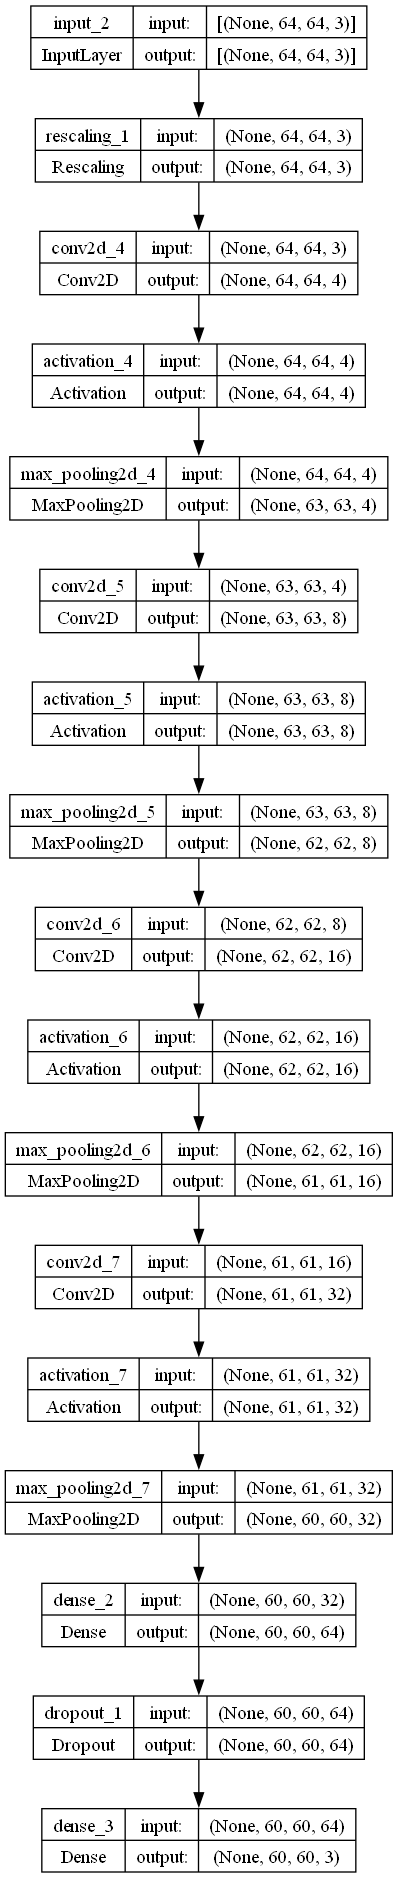

In [44]:
tf.keras.utils.plot_model(model, to_file='model_archi_04.png', show_shapes=True)

# Model Training

In [48]:
# Compile the model with the updated configuration
custom_optimizer = Adam(learning_rate=0.0005)  # Adjust learning rate as needed
hair_model.compile(
    optimizer=custom_optimizer,
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy", tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), tf.keras.metrics.AUC()],
)

# Define the number of epochs
epochs = 50

# Early stopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=8,
    restore_best_weights=True
)

# Training the Model

In [49]:
# Fit the model with data augmentation
history = hair_model.fit(
    datagen.flow(train_ds),
    epochs=epochs,
    validation_data=val_ds,
    callbacks=[early_stopping]
)

TypeError: float() argument must be a string or a real number, not '_PrefetchDataset'

In [ ]:
# Print the best epochs
best_epoch_loss = np.argmin(history.history['val_loss'])
best_epoch_accuracy = np.argmax(history.history['val_accuracy'])
print(f'Best Epoch for Validation Loss: {best_epoch_loss}')
print(f'Best Epoch for Validation Accuracy: {best_epoch_accuracy}')

AttributeError: 'NoneType' object has no attribute 'history'

In [ ]:
import matplotlib.pyplot as plt

# Plot training history for loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Mark the best epoch for validation loss
best_epoch_loss = np.argmin(history.history['val_loss'])
plt.axvline(x=best_epoch_loss, color='r', linestyle='--', label=f'Best Epoch Loss: {best_epoch_loss}')
plt.legend()

# Plot training history for accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Mark the best epoch for validation accuracy
best_epoch_accuracy = np.argmax(history.history['val_accuracy'])
plt.axvline(x=best_epoch_accuracy, color='r', linestyle='--', label=f'Best Epoch Accuracy: {best_epoch_accuracy}')
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
# Print the best epochs
print(f'Best Epoch for Validation Loss: {best_epoch_loss}')
print(f'Best Epoch for Validation Accuracy: {best_epoch_accuracy}')

# Model Testing and Evaluation

In [ ]:
# Load and test an image of curly hair
img_curly = keras.preprocessing.image.load_img(
    "hair_types/Curly_Hair/02dac897d1dec9ba8c057a11d041ada8--layered-natural-hair-natural-black-hairstyles.jpg", target_size=image_size
)
img_array_curly = keras.preprocessing.image.img_to_array(img_curly)
img_array_curly = tf.expand_dims(img_array_curly, 0)  # Create batch axis

predictions_curly = model.predict(img_array_curly)
print(
    "CURLY: This image is %.2f percent curly hair, %.2f percent straight hair, and %.2f percent wavy hair."
    % tuple(predictions_curly[0])
)

# Load and test an image of straight hair
img_straight = keras.preprocessing.image.load_img(
    "hair_types/Straight_Hair/1-short-spiky-mens-haircut.jpg", target_size=image_size
)
img_array_straight = keras.preprocessing.image.img_to_array(img_straight)
img_array_straight = tf.expand_dims(img_array_straight, 0)  # Create batch axis

predictions_straight = model.predict(img_array_straight)
print(
    "STRAIGHT: This image is %.2f percent curly hair, %.2f percent straight hair, and %.2f percent wavy hair."
    % tuple(predictions_straight[0])
)

# Load and test an image of wavy hair
img_wavy = keras.preprocessing.image.load_img(
    "hair_types/Wavy_Hair/2-Short-High-Volume-Hairstyle.jpg", target_size=image_size
)
img_array_wavy = keras.preprocessing.image.img_to_array(img_wavy)
img_array_wavy = tf.expand_dims(img_array_wavy, 0)  # Create batch axis

predictions_wavy = model.predict(img_array_wavy)
print(
    "WAVY: This image is %.2f percent curly hair, %.2f percent straight hair, and %.2f percent wavy hair."
    % tuple(predictions_wavy[0])
)

1ADDED: give you insights into how well your model generalizes to new, unseen data based on your validation dataset

AUC = 0.5: The model performs no better than random chance.

AUC < 0.5: The model performs worse than random chance.

AUC > 0.5: The model has some discriminatory power, with higher values indicating better discrimination.

In [ ]:
val_loss, val_accuracy, val_precision, val_recall, val_auc = model.evaluate(val_ds)
print(f"Validation Accuracy: {val_accuracy}")
print(f"Validation Precision: {val_precision}")
print(f"Validation Recall: {val_recall}")
print(f"Validation AUC: {val_auc}")

In [ ]:
import tensorflow as tf
from tensorflow import keras

# Assuming val_ds is your validation dataset
val_images = []
val_labels = []

for images, labels in val_ds.take(3):  # Take 3 batches (adjust as needed)
    val_images.append(images)
    val_labels.append(labels)

# Concatenate the batches to get the images and labels
val_images = tf.concat(val_images, axis=0)
val_labels = tf.concat(val_labels, axis=0)

# Test the model on the selected validation images
predictions = model.predict(val_images)

for i in range(len(val_images)):
    print(f"Image {i + 1} - Filename: {val_filenames[i]}:")
    print(f"True Label: {val_labels[i]}")
    print(f"Predictions: {predictions[i]}")
    print()
